In [3]:
#Import required packages 
import numpy as np

import pandas as pd
import pandas_profiling

from datetime import datetime

import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import Bitcoin Scrapped Dataset and Preprocess

In [ ]:
#Import Bitcoin Barchart Data
bitcoin_price_history_df = pd.read_csv('./data/price_history_4_year_hourly.csv')

### Note: All financial columns are in U.S Dollars
- Open  
- Close 
- Low   
- High  
- Volume (Currency) 
- Weighted Price

In [ ]:
bitcoin_price_history_df.sample(5)

In [ ]:
#strip column names of any space and lowercase
bitcoin_price_history_df.rename(columns=lambda x: x.strip())
bitcoin_price_history_df.columns = bitcoin_price_history_df.columns.str.lower()

#Reconfigure Date to DateTime
bitcoin_price_history_df.timestamp = pd.to_datetime(bitcoin_price_history_df.timestamp, format="%m/%d/%Y %H:%M")

In [ ]:
#Verify All Column DataTypes Are Int64
bitcoin_price_history_df.dtypes

In [ ]:
# #Save Updated Data Frame
with open('./data/bitcoin_4_year_hourly_history_df.pickle', 'wb') as file:
     pickle.dump(bitcoin_price_history_df, file)     

### Chart Bitcoin Price History Across Past 2.5 Years to look for spikes in the data

In [4]:
#Load bitcoin_price_history dataframe
with open('./data/bitcoin_4_year_hourly_history_df.pickle', 'rb') as file:
     bitcoin_price_history_df = pickle.load(file)

In [5]:
#Split data frame to previous 2.5 years only January 2017 - June 2019
bitcoin_price_df_last_2_5_years = bitcoin_price_history_df[bitcoin_price_history_df.timestamp > '2017-01-01 00:00:00'].loc[:,['timestamp','weighted price']]

In [6]:
#Sort Dataframe By Date
bitcoin_price_df_last_2_5_years.sort_values('timestamp', inplace=True)

#Reset Dataframe Row Index
bitcoin_price_df_last_2_5_years = bitcoin_price_df_last_2_5_years.reset_index(drop=True)

In [7]:
#Convert all string dates to datetime
bitcoin_price_df_last_2_5_years.timestamp = pd.to_datetime(bitcoin_price_df_last_2_5_years.timestamp).dt.date

In [8]:
#Average price across day last 2.5 years
average_daily_bitcoin_price_2_5_years = bitcoin_price_df_last_2_5_years.groupby(['timestamp'],as_index=False).mean()

In [9]:
def graph_price_history(bitcoin_data, file_name):
    """
    This function plots a graph of bitcoin prices across days of week for last 2.5 years
    bitcoin_data : Sentiment Data Average Across Last 2.5 Years
    file_name: Name of file that image of graph will be saved as
    """
    fig, ax = plt.subplots(figsize=(20, 15));
    plt.figure(dpi=600);

    x_axis = [x for x in range(len(bitcoin_data))]
    ax.set_ylabel('Price in U.S Dollars', fontsize=20)

        
    ax.set_xlabel('Day', fontsize=20)
    ax.set_title ('Price of Bitcoin From 01-01-2017 to 06-01-2019', fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
    ax.plot(x_axis,bitcoin_data);
    
    fig.tight_layout()
    
    fig.savefig('./graphs/'+file_name+'.png', dpi=600)
    return ax

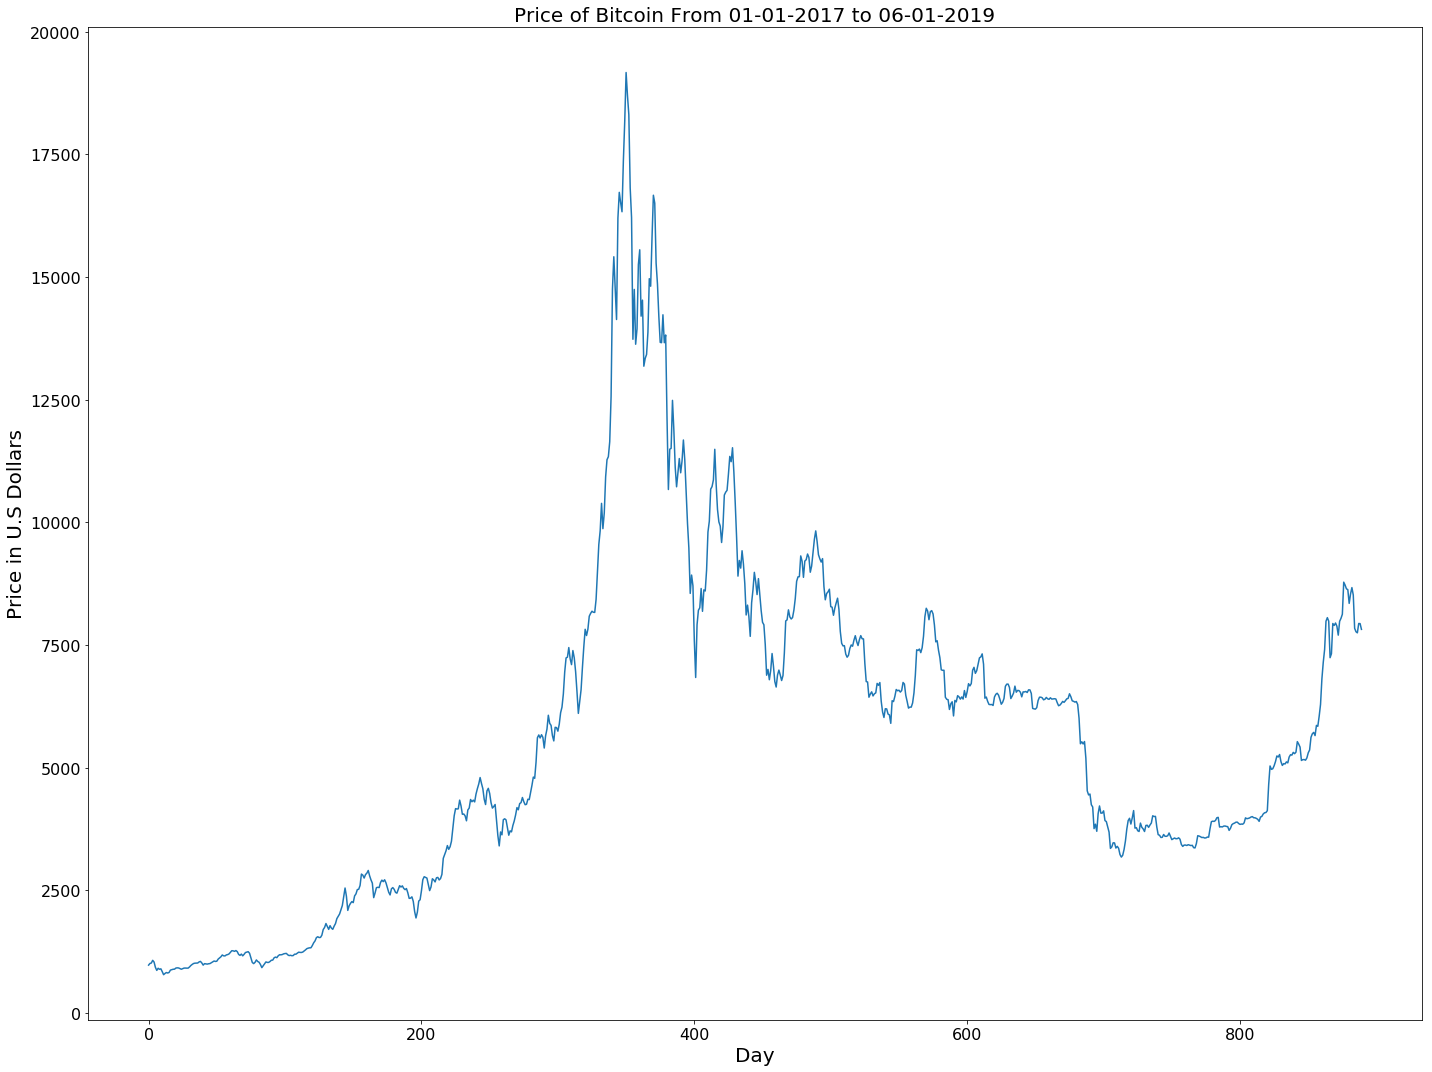

<Figure size 3600x2400 with 0 Axes>

In [10]:
graph_price_history(average_daily_bitcoin_price_2_5_years['weighted price'], 'bitcoin_average_price_history_2_5_years')

### Calculate largest average price postiive and negative percent difference across 20 day intervals. Will utilize these dates in conjection with article sentiment data to identify if sentiment drove prices of bitcoin

In [11]:
average_daily_bitcoin_price_2_5_years.head(2)

,timestamp,weighted price
0,2017-01-01,977.799565
1,2017-01-02,1011.706250


In [12]:
#Calculate largest percent difference in 20 day intervals. 
average_daily_bitcoin_price_2_5_years['price_percent_change'] = average_daily_bitcoin_price_2_5_years['weighted price'].pct_change(axis=0)*100
average_daily_bitcoin_price_2_5_years.dropna(inplace=True)

In [13]:
average_daily_bitcoin_price_2_5_years.head(5)

,timestamp,weighted price,price_percent_change
1,2017-01-02,1011.706250,3.467652
2,2017-01-03,1019.904167,0.810306
3,2017-01-04,1075.525000,5.453535
4,2017-01-05,1040.972083,-3.212656
5,2017-01-06,931.960833,-10.472063


In [20]:
#Save average daily bitcoin price dataframe
with open('./data/average_daily_bitcoin_price_2_5_years.pickle', 'wb') as file:
     pickle.dump(average_daily_bitcoin_price_2_5_years, file)

In [14]:
average_daily_bitcoin_price_2_5_years_bins = np.array_split(average_daily_bitcoin_price_2_5_years, 45)

In [17]:
largest_positive_change_bins_values_and_dates = []

largest_negative_change_bins_values_and_dates = []

for bin in average_daily_bitcoin_price_2_5_years_bins:
    #Calculate largest positive changes and add to lists above
    largest_postive_change = bin[bin['price_percent_change'] > 0].nlargest(1, 'price_percent_change')
    largest_positive_change_bins_values_and_dates.append([largest_postive_change.price_percent_change.iloc[0],\
                                                          largest_postive_change.timestamp.iloc[0]])
    
    #Calculate largest negative changes and add to lists above
    largest_negative_change = bin[bin['price_percent_change'] < 0].nsmallest(1, 'price_percent_change')
    largest_negative_change_bins_values_and_dates.append([largest_negative_change.price_percent_change.iloc[0],\
                                                        largest_negative_change.timestamp.iloc[0]])

In [19]:
#Save Lists
with open('./data/largest_positive_change_bins_values_and_dates.pickle', 'wb') as file:
     pickle.dump(largest_positive_change_bins_values_and_dates, file)
        
with open('./data/largest_negative_change_bins_values_and_dates.pickle', 'wb') as file:
     pickle.dump(largest_negative_change_bins_values_and_dates, file)